# Inspect GALEX drift scan data sets

In [1]:
%matplotlib widget

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import re
import warnings
from pprint import pprint
from glob import glob
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
from scipy.stats import chi2, binned_statistic
import numpy as np

from astropy.utils.exceptions import AstropyWarning
from astropy import units as uu
from astropy.table import Table, vstack
from astropy.time import Time
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.visualization.wcsaxes import SphericalCircle
import h5py
from sklearn.cluster import MeanShift

import vasca.utils as vutils
from vasca.field import BaseField
import vasca.visualization as vvis

In [4]:
def ds_base_name(fd, sv, v, prod):
    
    if prod == "mcat":
        prod = f"xd-{prod}"
    else:
        prod = f"nd-{prod}"
    
    name = (
        "WTTHV2_"
        f"{str(fd).zfill(3)}_"
        f"{str(v).zfill(4)}_"
        f"sv{str(sv).zfill(2)}"
        f"-{prod}.fits"
    )
    return name

In [5]:
#vis_dir = "/Users/julianschliwinski/GALEX_DS/scan040_sv16"
vis_dir = "/Users/julianschliwinski/GALEX_DS/galex_drift_scan_wis"

## LAST pipeline output

In [6]:
file = f"{vis_dir}/MatchedSources.hdf5"
hdf = h5py.File(file, 'r')
for i in hdf:
    print(i, hdf[i].shape)

Dec (492, 14)
FLAGS (492, 14)
JD (1, 14)
MAGERR_CONV_2 (492, 14)
MAGERR_CONV_3 (492, 14)
MAGERR_PSF (492, 14)
MAG_CONV_2 (492, 14)
MAG_CONV_3 (492, 14)
MAG_PSF (492, 14)
MergedCatMask (492, 14)
PSF_CHI2DOF (492, 14)
RA (492, 14)
SN (492, 14)
SN_1 (492, 14)
SN_2 (492, 14)
SN_3 (492, 14)
SN_4 (492, 14)
X (492, 14)
X1 (492, 14)
Y (492, 14)
Y1 (492, 14)


## Create VASCA field

In [7]:
# Build field step by step
fd = BaseField()

### Create tt_fields

In [8]:
# Get field info from single mcat file
fname = ds_base_name(40, 16, 1, "mcat")
info_keys = [
    "OBJECT",
    "TILENAME",
    "IMG",
    "TILENUM",
    "PLANID",
    "VISIT",
    "SUBVIS",
    "LEG",
    "RA_CENT",
    "DEC_CENT",
]
field_info_raw = {}
with fits.open(f"{vis_dir}/{fname}") as hdul:
    #hdul.info()
    for key in info_keys:
        field_info_raw[key] = hdul[0].header[key]
        print(f"{key:<10} {hdul[0].header[key]:>25}")

field_info = dict()
field_info["field_id"] = [field_info_raw["TILENUM"]]
field_info["field_name"] = [field_info_raw["TILENAME"]]
field_info["ra"] = [field_info_raw["RA_CENT"]]
field_info["dec"] = [field_info_raw["DEC_CENT"]]
field_info["observatory"] = ["GALEXDS"]
field_info["obs_filter"] = ["NUV"]
field_info["fov_diam"] = [1.2]

fd.add_table(field_info, "base_field:tt_fields")
fd.tt_fields

OBJECT          WTTHV2_040_0001_sv16
TILENAME                  WTTHV2_040
IMG                             2049
TILENUM                        29139
PLANID                         29139
VISIT                              1
SUBVIS                            16
LEG                               16
RA_CENT             258.868553056012
DEC_CENT            35.2422725955026


<Table length=1>
field_id field_name        ra              dec        observatory obs_filter fov_diam sel 
                          deg              deg                                 deg        
bytes22   bytes22       float64          float64        bytes22     bytes8   float32  bool
-------- ---------- ---------------- ---------------- ----------- ---------- -------- ----
   29139 WTTHV2_040 258.868553056012 35.2422725955026     GALEXDS        NUV      1.2 True

### Create tt_visits

In [9]:
# Crawl visit directory and get info for each mcat file

vasca_col_names = [
    "vis_id",
    "time_bin_start",
    "time_bin_size",
    "time_bin_size_alt_filt",
    "ra",
    "dec",
]
f_info = dict.fromkeys(vasca_col_names)
for k in f_info:
    f_info[k] = list()
    
f_list = glob(f"{vis_dir}/WTTHV2_*mcat.fits")
f_list_good = list()
for path in f_list:
    f_name = path.split(os.sep)[-1]

    obj_name = f_name.rstrip("-xd-mcat.fits")
    
    # Parse object name
    filter = r"^(?P<projname>WTTHV2)_(?:0*(?P<id_drift>\d+))_(?:0*(?P<id_vis>\d+))_sv(?:0*(?P<id_subvis>\d+))$"
    match  = re.search(filter, obj_name)
    match_fields = match.groupdict()
    
    info_keys = [
        "IMG",
        "OBSDATIM",
        "EXPTIME",
        "EXPTIME",
        "RA_CENT",
        "DEC_CENT",
    ]

    try:
        field_info_raw = {}
        with fits.open(f"{vis_dir}/{f_name}") as hdul:
            #hdul.info()
            for key in info_keys:
                field_info_raw[key] = hdul[0].header[key]
        
        f_list_good.append(path)

    except(OSError):
        continue

    for vasca_col, mcat_col in zip(vasca_col_names, info_keys):
        if mcat_col == "OBSDATIM":
            f_info[vasca_col].append(
                Time(
                    datetime.strptime(field_info_raw[mcat_col], "%y%m%dT%H%M%SZ")
                ).mjd
            )
        else:
            f_info[vasca_col].append(field_info_raw[mcat_col])

# Sets table as class attribute
fd.add_table(f_info, "galex_field:tt_visits")
fd.tt_visits

<Table length=14>
vis_id   time_bin_start   time_bin_size sel  time_bin_size_alt_filt        ra              dec       
               d                s                      s                  deg              deg       
int64       float64          float32    bool        float64             float64          float64     
------ ------------------ ------------- ---- ---------------------- ---------------- ----------------
  2065       56127.078125          52.0 True                   52.0 258.868553056012 35.2422725955026
  2061 56115.579664351855         121.0 True                  121.0 258.868553056012 35.2422725955026
  2063  56121.60144675926         112.0 True                  112.0 258.868553056012 35.2422725955026
  2057 56099.703726851854         124.0 True                  124.0 258.868553056012 35.2422725955026
  2058  56103.80960648148         124.0 True                  124.0 258.868553056012 35.2422725955026
  2062  56118.79571759259         118.0 True                  118.0 258.868553056012 35.2422725955026
  2056  56095.73494212963        114.05 True                 114.05 258.868553056012 35.2422725955026
  2068  56135.29415509259         94.05 True                  94.05 258.868553056012 35.2422725955026
  2066  56129.81659722222         75.05 True                  75.05 258.868553056012 35.2422725955026
  2052  56084.03234953704         82.05 True                  82.05 258.868553056012 35.2422725955026
  2049 56075.814988425926         83.05 True                  83.05 258.868553056012 35.2422725955026
  2067  56132.55567129629         80.05 True                  80.05 258.868553056012 35.2422725955026
  2051 56081.293391203704         71.05 True                  71.05 258.868553056012 35.2422725955026
  2050  56078.55400462963         73.05 True                  73.05 258.868553056012 35.2422725955026

### Set field info attributes

In [10]:
# Sets convenience class attributes
fd.set_field_attr()

In [11]:
fd.center

<SkyCoord (ICRS): (ra, dec) in deg
    (258.86855306, 35.2422726)>

### Create tt_detections

In [12]:
mcat_col_names = [
    "visit_id",
    "ggoid_dec",
    "alpha_j2000",
    "delta_j2000",
    f"nuv_poserr",
    f"nuv_flux",
    f"nuv_fluxerr",
    f"nuv_s2n",
    "fov_radius",
    f"nuv_artifact",
    f"NUV_CLASS_STAR",
    "chkobj_type",
    f"NUV_FLUX_APER_4",
    f"NUV_FLUXERR_APER_4",
    f"NUV_FLUX_APER_3",
    f"NUV_FLUXERR_APER_3",
    "E_bv",
    f"nuv_mag",
    f"nuv_magerr",
]

vasca_col_names = [
    "vis_id",
    #"fd_src_id",
    "det_id",
    "ra",
    "dec",
    "pos_err",
    "flux",
    "flux_err",
    "s2n",
    "r_fov",
    "artifacts",
    "class_star",
    "chkobj_type",
    "flux_f60",
    "flux_f60_err",
    "flux_f38",
    "flux_f38_err",
    "E_bv",
    "mag",
    "mag_err",
]

# Loops over mcat files
for i, path in enumerate(f_list_good):
    # Get visit ID
    with fits.open(path) as hdul:
        vis_id = hdul[0].header["IMG"]
    # Load mcat as table
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", AstropyWarning)
        tt_mcat = Table.read(path)
    # Add visit ID
    tt_mcat.add_column(
        np.full(len(tt_mcat), vis_id), name="visit_id", index=0
    )
    # Add filter ID
    tt_mcat.add_column(
        np.full(len(tt_mcat), vutils.dd_filter2id["NUV"]), name="obs_filter_id"
    )
    
    tt_mcat = tt_mcat[mcat_col_names]
    
    if i == 0:
        tt_detections = tt_mcat.copy()
    else:
        tt_detections = vstack([tt_detections, tt_mcat])

dd_detections = {}
col_names = dict(zip(mcat_col_names, vasca_col_names))
for col in mcat_col_names:
    dd_detections[col_names[col]] = tt_detections[col].data
    
fd.add_table(dd_detections, "galex_field:tt_detections")
fd.tt_detections

<Table length=56145>
vis_id fd_src_id         ra                dec          pos_err      flux     flux_err ...   flux_f60  flux_f60_err  flux_f38  flux_f38_err     E_bv       mag      mag_err  
                        deg                deg           arcsec    1e-06 Jy   1e-06 Jy ...                                                                 mag        mag    
int64    int32        float64            float64        float32    float32    float32  ...   float32     float32     float32     float32      float32    float32    float32  
------ --------- ------------------ ------------------ ---------- ---------- --------- ... ----------- ------------ ---------- ------------ ----------- --------- -----------
  2065        -1 258.50616081955155  34.75776840330148 0.47806352  1061.1371  40.13368 ...   20.878399    1.0281774  13.119132    0.8609156 0.026724678  16.33557  0.04107403
  2065        -1  258.7227522714717 34.740169634495814 0.47929856   894.1709 38.166664 ...   14.940441   0.90278786   8.872796    0.7305126 0.026181376 16.521448  0.04635467
  2065        -1 258.13145609916666  34.84399037495137  0.4785979  7101.5464  82.90725 ...   50.624756    1.3270303   22.44607    0.9602756 0.023537315 14.271617 0.012678544
  2065        -1  258.7344001020054  34.72434946895091  1.1502593   16.86057  7.789092 ...  0.30684224   0.18697716 0.18401201   0.15279001  0.02482204 20.832819   0.5017003
  2065        -1 258.67036294477776  34.71810324265524 0.77544826  4.4545956 3.9590366 ... 0.071132615   0.11737888 0.15050025   0.11737886 0.025776345 22.277979  0.96518606
  2065        -1  258.6770134735639   34.7255584490607 0.79777586  22.546139  8.448735 ...   0.5904337   0.23718064 0.42890358   0.19558199 0.026181376 20.517319  0.40695778
  2065        -1 258.66268682497645 34.722753176037436 0.70936215  7.9006433 4.7963066 ...  0.21745467   0.16242877  0.2493099   0.14220254 0.026203811 21.655844   0.6592867
  2065        -1  258.5907207376019  34.73595108538661  0.6037825   82.21225 13.806786 ...    1.601119    0.3519397  1.1152514    0.2748707 0.026651109 19.112658  0.18238364
  2065        -1 258.63647193964727  34.72432531338501 0.89916766   9.905166 5.1977005 ...  0.23798761   0.15410322 0.19318317    0.1541032 0.026203811 21.410345   0.5698747
  2065        -1   258.681496299137  34.72453970988249  0.7028114   7.184229 4.4056215 ...  0.13905537   0.15099777 0.22594436   0.13061938 0.026181376 21.759048  0.66597337
  2065        -1  258.8327970563203  34.72723744339325 0.99388665  15.952895  7.236979 ...  0.49340063   0.22942439 0.24780768   0.14067025 0.024271665   20.8929  0.49266037
  2065        -1 258.59150786967365   34.7264493124631  0.6682273  7.0132165   4.45263 ...  0.13924347   0.13201311 0.22584355    0.1320131 0.026651109 21.785206   0.6894919
  2065        -1  258.6596040746314  34.72669820361983  0.7720825   6.478592 4.3745346 ...  0.20834774   0.14983153  0.2216706    0.1296977 0.026203811 21.871298   0.7332989
  2065        -1  258.8483151951044   34.7292007539059  0.9008476  13.255351  6.573886 ...  0.45249012    0.1949048 0.40061682   0.17731223 0.024389407  21.09402  0.53859305
  2065        -1  258.8718238859434  34.73186632711812  0.7503324   7.076983 5.4618073 ...  0.26378748   0.16193351  0.3437933   0.16193351 0.024389407  21.77538   0.8381429
  2065        -1   258.563859331413 34.731686253662275  0.7761128  7.7292786  4.677572 ...  0.15455282    0.1595317 0.24182303   0.13868225 0.026651109 21.679651  0.65722084
  2065        -1  258.6173044030003  34.73230052336879 0.71156114  15.744293 6.6471434 ...  0.47193155   0.19707677  0.3786424   0.18535188 0.026203811  20.90719   0.4585025
  2065        -1 258.90522135782163  34.73435935877249  0.9208791  13.917029 7.2533135 ...    0.371404   0.21541268  0.3018155   0.16307785 0.025105422 21.041132   0.5660043
   ...       ...                ...                ...        ...        ...       ... ...         ...          ...        ...          ...         ...

### Load reference image

In [13]:
# LAST pipeline coadd
fd.load_sky_map(f"{vis_dir}/Ref_WTTHV2_040_sv16_Nim14-nd-int.fits")
# GALEX pipeline visit intenisity map
#fd.load_sky_map("/Users/julianschliwinski/GALEX_DS/scan040_sv16/WTTHV2_040_0001_sv16-nd-int.fits")

## Selection and clustering

### Detection quality cuts

In [14]:
selection = {
    "det_quality": {
        "table"       : "tt_detections",
        "presel_type" : "and",
        "sel_type"    : "and",

        # See variable description http://www.galex.caltech.edu/wiki/Public:Documentation/Appendix_A.1
        "range": {
                "s2n"            : [3.5,np.inf],
                "r_fov"          : [0.0,0.55],
                "class_star"     : [0.6,1.0],        # Extension classifier (extended=0, point like=1)
                "chkobj_type"    : [-0.5,0.5],      # Matched to a bright star (0=no, 1=yes)
        },
        "bitmask": {
                # Specify the artifacts to remove
                # For GALEX a description is at the end of this document
                "artifacts" : [1,2,4,8,16,32,64,128,256],
        },
        #If below/above this value will set it to min/max
        "set_range": {
                "pos_err" : [0.5,5], # In arcsec
        },
    },
    "src_variability": {
        "table"       : "tt_sources",
        "presel_type" : "and",
        "sel_type"    : "and",
        "obs_filter"  : "NUV",                             # Select filter to apply cut on, see vasca.utils.dd_filter_id for definitions
        "range": {
            "nr_det"         : [2,np.inf],
            "pos_cpval"      : [0.0000000001,np.inf],            
            "flux_cpval"     : [-0.5,0.000000573303],   # 5 sigma, see https://en.wikipedia.org/wiki/Normal_distribution
            "flux_nxv"       : [0.0006,np.inf],           # Excess variance above ~sqrt(cut)*100%  
            "flux"           : [0.144543,575.43],      # Flux in 1e-6Jy, mag 17-26, see conversion table to AB magnitudes at the end
        },
    },
}

In [15]:
pprint(selection, sort_dicts=False)

{'det_quality': {'table': 'tt_detections',
                 'presel_type': 'and',
                 'sel_type': 'and',
                 'range': {'s2n': [3.5, inf],
                           'r_fov': [0.0, 0.55],
                           'class_star': [0.6, 1.0],
                           'chkobj_type': [-0.5, 0.5]},
                 'bitmask': {'artifacts': [1, 2, 4, 8, 16, 32, 64, 128, 256]},
                 'set_range': {'pos_err': [0.5, 5]}},
 'src_variability': {'table': 'tt_sources',
                     'presel_type': 'and',
                     'sel_type': 'and',
                     'obs_filter': 'NUV',
                     'range': {'nr_det': [2, inf],
                               'pos_cpval': [1e-10, inf],
                               'flux_cpval': [-0.5, 5.73303e-07],
                               'flux_nxv': [0.0006, inf],
                               'flux': [0.144543, 575.43]}}}


In [16]:
# Apply detections selections
fd.select_rows(selection["det_quality"], remove_unselected=False)

In [17]:
fd.tt_detections[fd.tt_detections["sel"]]

<Table length=11268>
vis_id fd_src_id         ra                dec          pos_err      flux    flux_err ...  flux_f60  flux_f60_err  flux_f38  flux_f38_err     E_bv       mag      mag_err   
                        deg                deg           arcsec    1e-06 Jy  1e-06 Jy ...                                                                mag        mag     
int64    int32        float64            float64        float32    float32   float32  ...  float32     float32     float32     float32      float32    float32    float32   
------ --------- ------------------ ------------------ ---------- --------- --------- ... ---------- ------------ ---------- ------------ ----------- --------- ------------
  2065        -1 258.52661988267494 34.847231672719005 0.61780393  69.62998  8.588657 ...  1.4645705   0.20836917 0.84292704   0.17391425 0.027567856 19.293009   0.13395496
  2065        -1 258.01013234404815 34.870216414871535  0.5037647 150.18478 12.170052 ...  3.5153036   0.32416475  2.2615013     0.282061 0.021341633 18.458435   0.08800276
  2065        -1  258.5143239638977  34.88171888101633 0.52579004  70.37364 7.7602158 ...  1.8884768    0.2124775  1.5493904   0.20227627 0.028573783 19.281473  0.119754985
  2065        -1 258.36314548223123  34.89201939873855  1.0711012 14.059415 3.6860592 ... 0.35537788   0.10691386 0.26335397   0.08751189 0.029600075  21.03008   0.28472453
  2065        -1  258.4147504155675  34.89453761961625  0.7534265 14.466978 3.7335572 ... 0.38930184  0.108097225 0.35520568  0.097036324  0.02831695 20.999054   0.28026885
  2065        -1 258.50953294848756 34.904579096399786        0.5 166.16745 11.465797 ...  4.1011286   0.31425893  2.7671778   0.27588245 0.028906588 18.348635   0.07493559
  2065        -1  258.5998531806041 34.902600837563135  0.6487941  41.84018 6.6321487 ...  1.0625159    0.1752896  0.5625344   0.13936138 0.028356558 19.846016   0.17214347
  2065        -1     258.1579092185  34.91260579374118 0.65420127 30.895275 6.0166383 ...  0.8871094   0.15166806  0.5813382   0.12935409 0.024477232 20.175268   0.21149088
  2065        -1 258.13184062470924 34.949325934270135        0.5  5139.003  59.38607 ... 108.235954    1.5616096  66.788895    1.3330575 0.024772596 14.622802 0.0125497645
  2065        -1  258.0033705563489  34.90952564643849  0.6367895 38.872723 6.1977773 ...  0.9476857   0.15774633  0.6830423   0.14003715 0.022518935 19.925886   0.17314933
  2065        -1  258.4012639134845  34.91148700577948  1.2399724   30.1757  6.684543 ... 0.44721138   0.10983855 0.26700008  0.090848275 0.029841114 20.200855   0.24057151
  2065        -1  258.5709153589082  34.92620879816786   1.286714 16.608171 4.2998023 ...  0.3167434   0.10966038 0.21499886   0.08421991 0.028356558 20.849194    0.2811619
  2065        -1  258.5531607197549  34.94151384319717  0.9272805 24.168385  5.190667 ...  0.5492516   0.12307159 0.34959945    0.0991505 0.029145451  20.44188   0.23324126
  2065        -1 258.33032776727845 34.945634440798486  1.4779644  19.41147  4.539116 ... 0.37486997  0.100892015 0.24437875   0.08187965  0.03017627 20.679853   0.25394675
  2065        -1  258.2862220769682    34.939746446886  0.7797487 16.174208  3.774869 ... 0.53907555   0.10805501 0.31220388   0.09670872   0.0284363 20.877941   0.25345957
  2065        -1    258.21556304282 34.953631533933084  1.4180499 12.743724 3.6138816 ... 0.24739149   0.08853813 0.16682489   0.07253588 0.026114281 21.136759   0.30796927
  2065        -1  258.4761980081729 34.970416145662526 0.67719716 18.258766  4.061902 ... 0.55334204   0.12042865  0.5050513   0.11116484 0.029928956  20.74632   0.24159494
  2065        -1 258.35209057315495  34.98257126971231  1.1514925 12.047452 3.3313816 ... 0.34118018   0.09877634  0.1886045    0.0683742 0.030770725 21.197762   0.30030254
   ...       ...                ...                ...        ...       ...       ... ...        ...          ...        ...          ...         ...       ...          ...


### Clustering

In [18]:
cluster_det = {
        "meanshift": {
            "bandwidth"     : 5,
            "seeds"         : None,
            "bin_seeding"   : False,
            "min_bin_freq"  : 1,
            "cluster_all"   : True,
            "n_jobs"        : 3,
            "max_iter"      : 300,
            "table_name"    : "tt_detections",
        }
}

In [19]:
# Run clustering
fd.cluster_meanshift(
    **cluster_det["meanshift"],
)

5085

#### Manual MeanShift

In [20]:
coords = vutils.table_to_array(fd.tt_detections[fd.tt_detections["sel"]]["ra","dec"])
bw = (cluster_det["meanshift"]["bandwidth"] * uu.arcsec).to(uu.deg).value
ms = MeanShift(
    **{
        **{
            k:cluster_det["meanshift"][k]
            for k in [
                "seeds",
                "bin_seeding",
                "min_bin_freq",
                "cluster_all",
                "n_jobs",
                "max_iter",
            ]
        },
        "bandwidth":bw
    }
)
ms.fit(coords)
len(np.unique(ms.labels_))

5085

### Variability cuts

In [21]:
fd.add_table({"obs_filter_id":[0], "obs_filter":["NUV"], "obs_filter_idx":[-1]},"region:tt_filters")
# Calculate source variables from light curve
fd.set_src_stats(src_id_name = "fd_src_id")

In [22]:
# Select variable sources
fd.select_rows(selection["src_variability"], remove_unselected=False)

In [23]:
fd.tt_sources

<Table length=5085>
fd_src_id  nr_det          ra                dec          pos_err      pos_nxv     ...   flux_nxv    flux_var    flux_cpval  flux_rchiq assoc_ffactor assoc_fdiff_s2n
                          deg                deg           arcsec                  ...              1e-12 Jy2                                                        
  int32   int32[1]      float64            float64        float32      float32     ...  float32[1]  float32[1]   float32[1]  float32[1]    float32        float32    
--------- -------- ------------------ ------------------ ---------- -------------- ... ------------ ---------- ------------- ---------- ------------- ---------------
        0       14  258.5347595243532  35.51409577246547 0.13363062  -5.054034e-12 ...  0.009620929  2700.8137           0.0  21.488817        -100.0        -10000.0
        1       14    257.97818783939  35.03875059634047 0.15031686  1.4250191e-13 ...  0.004445333   26.77902   0.094802044  1.5397232        -100.0        -10000.0
        2       14  257.9504515380369  35.52782701554327 0.23539282 -1.1372707e-11 ... -0.012650477   6.048381     0.5077219  0.9418677        -100.0        -10000.0
        3       13 258.79037790623875   35.3902348991654 0.19164406  1.3610158e-12 ...  0.017889872   23.37789   0.011038413  2.1595051        -100.0        -10000.0
        4       13  258.7472079513991  35.41860780481523 0.24589066   7.519228e-11 ...   0.09254986  20.496698 3.5347646e-05  3.4871922        -100.0        -10000.0
        5       13  258.7258890085921 35.411411467531074 0.13867505  5.7975963e-12 ... 0.0017112901  157753.98           0.0  58.544846        -100.0        -10000.0
        6       13  258.6384173213169  35.06900783771947 0.19130826  1.0582597e-11 ...  0.053840842  28.713652  0.0014211893  2.6604085        -100.0        -10000.0
        7       13  258.6177068953904  35.44350418807864 0.27911922  3.9754857e-12 ...   0.38180792  49.511276  9.654575e-09  5.1681247        -100.0        -10000.0
        8       13 258.55645022312734 35.025557309138506 0.13922347  -4.748624e-12 ... 0.0046832026    90.5636  0.0007341736  2.8138678        -100.0        -10000.0
        9       13  258.5062846151158  35.39315146022217 0.13867505 -6.5936557e-12 ...  0.002569421  10274.746           0.0  26.974703        -100.0        -10000.0
       10       13  258.4822652866912  35.49930100370469  0.2214329  -5.827533e-12 ...   0.03401878   21.77507   0.012438732  2.1288025        -100.0        -10000.0
       11       13  258.4762207649423 34.970935765389804 0.21887341  1.2121646e-11 ...  0.011173127  11.061809    0.14607777  1.4245399        -100.0        -10000.0
       12       13  258.3772434185994 35.038179637863294  0.1448061  -6.256581e-12 ... 0.0036853873  49.421967   0.062146075  1.6891747        -100.0        -10000.0
       13       13 258.35176129870814 34.982403115663814 0.25882858 1.07876616e-11 ...  0.019410515   9.475631   0.044518765  1.7852513        -100.0        -10000.0
       14       13  258.2428046310564  35.46438292501268 0.21361332  -9.764777e-12 ...    0.0416082   13.75353  0.0011372243  2.7125456        -100.0        -10000.0
       15       13 258.17118933581577 35.590958803446036 0.14869222 -1.8444025e-12 ...  0.013183261  54.135876  3.374602e-05   3.497172        -100.0        -10000.0
       16       13  258.1682054363631  35.48195395643977 0.19789438  -8.050601e-12 ...   0.05366218  28.476906 9.8189375e-06  3.7602034        -100.0        -10000.0
       17       13 258.15340551482944  35.49245462325249 0.23136973 -1.4441022e-11 ...   0.04771619  15.779798  0.0009889023  2.7450478        -100.0        -10000.0
      ...      ...                ...                ...        ...            ... ...          ...        ...           ...        ...           ...             ...
     5067        1 257.92538430452197   35.4120246199522  1.2388825         -100.0 ...       -100.0     -100.0          -1.0       -1.0        -100.0        -1000

In [24]:
fd.tt_sources[fd.tt_sources["sel"][:,0]]

<Table length=41>
fd_src_id  nr_det          ra                dec          pos_err      pos_nxv       pos_var   ...   flux_nxv    flux_var    flux_cpval  flux_rchiq assoc_ffactor assoc_fdiff_s2n
                          deg                deg           arcsec                    arcsec2   ...              1e-12 Jy2                                                        
  int32   int32[1]      float64            float64        float32      float32       float32   ...  float32[1]  float32[1]   float32[1]  float32[1]    float32        float32    
--------- -------- ------------------ ------------------ ---------- -------------- ----------- ... ------------ ---------- ------------- ---------- ------------- ---------------
        0       14  258.5347595243532  35.51409577246547 0.13363062  -5.054034e-12  0.11500859 ...  0.009620929  2700.8137           0.0  21.488817        -100.0        -10000.0
        7       13  258.6177068953904  35.44350418807864 0.27911922  3.9754857e-12   2.0041978 ...   0.38180792  49.511276  9.654575e-09  5.1681247        -100.0        -10000.0
       18       13  258.0679619797275  35.45155109416307 0.15587904  -5.899116e-12  0.16121708 ...  0.026537847   67.91724 5.6920403e-08  4.8157334        -100.0        -10000.0
       21       13  257.9189681760063  35.53090977000272 0.14997938    8.91022e-12   0.5034324 ...  0.019502625 113.497826 6.4108603e-13   7.018809        -100.0        -10000.0
       25       12 258.59710911600837 35.358862748758376  0.1847977 -3.6808806e-14  0.48885128 ...  0.069800325   48.14657  7.440784e-08   5.008779        -100.0        -10000.0
       30       12  258.5058525305125  35.52774545224917 0.25144592   2.389917e-11   1.5593054 ...   0.09221844  19.415318 4.6841635e-08  5.1084065        -100.0        -10000.0
       39       12  258.1388172341276  35.46164408612693 0.20111863   7.428141e-12   0.9561887 ...   0.09581251  58.151615 2.5219434e-08  5.2411723        -100.0        -10000.0
       40       12  258.1328754557994  35.48273731521827  0.1450542 -6.1762665e-12  0.08704447 ...  0.012146451  134.56892 1.4803791e-12   7.272085        -100.0        -10000.0
       42       12 258.09745033473405   35.6333641827955 0.14441541  2.2751403e-13  0.23266211 ...  0.011797829  224.08789 3.7498646e-12   7.082013        -100.0        -10000.0
       47       12  257.9942921271038   35.2266479364172 0.17199203 -4.9890543e-12  0.64324003 ...  0.038852446   52.96785 2.7906377e-10  6.1917357        -100.0        -10000.0
       53       12 257.94194090547285 35.141637500735506 0.14433756 -6.6341806e-12 0.113551095 ... 0.0138371065  1036.7812  2.512403e-35  17.511448        -100.0        -10000.0
       59       11 258.70879638769264  35.35881704120005 0.18407391 -2.6144312e-12  0.39001054 ...  0.059474956  63.457764  2.341067e-08   5.569533        -100.0        -10000.0
       63       11 258.57603873817396  35.61067262524532   0.152949 -3.5571253e-12  0.19622011 ...  0.008359832  245.38542  4.114582e-10  6.4965925        -100.0        -10000.0
       73       11 258.43686839209204  35.46558989262892 0.19250815  2.9905494e-13  0.34904456 ...    0.1260476  92.573364  8.002828e-22  12.394257        -100.0        -10000.0
       80       11   258.349240170523  35.64803088321537 0.24244194  -1.584306e-11  0.51616865 ...   0.09162006  46.051888 1.9997995e-11  7.1788206        -100.0        -10000.0
       90       11  258.2611929749397  35.55445950129769 0.15075567 -4.9024274e-12   0.1047444 ...  0.007843188  198.72795 4.1376067e-09  5.9695883        -100.0        -10000.0
      101       11  258.1316745410565  35.20550324447786 0.15389885  -3.831716e-12  0.18662408 ...  0.020394806  187.55602 4.1656534e-15    9.05503        -100.0        -10000.0
      133       10  258.5126434594356  35.53715134094972 0.15811388  -5.492018e-12  0.15805301 ... 0.0045705456   345.2628  7.813564e-09  6.2233777        -100.0        -10000.0
      ...      ...                ...                ...        ..

#### Look at interesting variables

In [25]:
tt_det = fd.tt_detections[fd.tt_detections["sel"]]
tt_src = fd.tt_sources[fd.tt_sources["sel"][:,0]]

##### Photometry

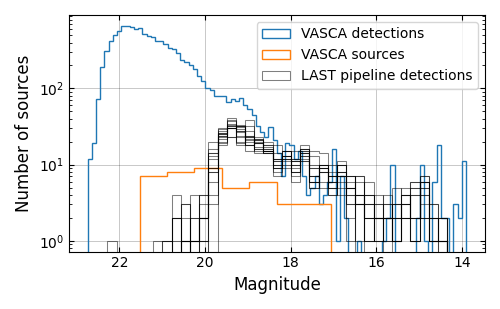

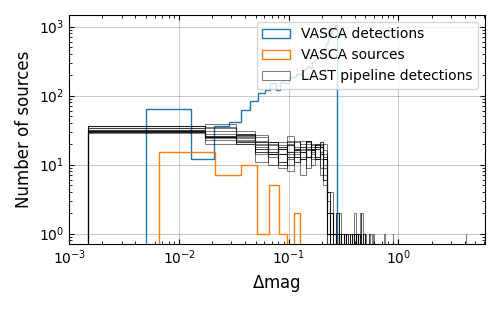

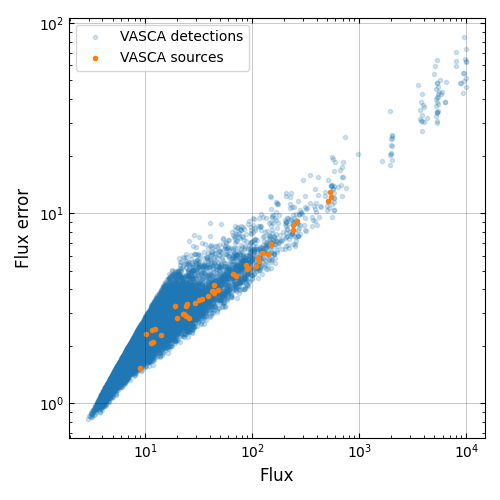

In [26]:
det_mag, det_mag_err = vutils.flux2mag(tt_det[tt_det["sel"]]["flux"],tt_det[tt_det["sel"]]["flux_err"])
src_mag, src_mag_err = vutils.flux2mag(tt_src[tt_src["sel"][:,0]]["flux"][:,0],tt_src[tt_src["sel"][:,0]]["flux_err"][:,0])

# Magnitude

fig, ax = vutils.nb_fig(num="mag", gr_size=5, layout="tight")

ax.hist(
    det_mag.data,
    histtype="step",
    bins="auto",
    label="VASCA detections"
)
ax.hist(
    src_mag.data,
    histtype="step",
    bins="auto",
    label="VASCA sources"
)
ax.hist(
    hdf["MAG_CONV_3"][:],
    histtype="step",
    bins="auto",
    alpha=0.5,
    color=["k"]*14,
    lw=0.75,
    label=["LAST pipeline detections", *["_" for i in range(13)]]
)

ax.set_xlabel(f"Magnitude", fontsize=12)
ax.set_ylabel("Number of sources", fontsize=12)

ax.set_yscale("log")
ax.invert_xaxis()

ax.grid(True, linewidth=0.5, color="k", alpha=0.3, zorder=0)
ax.tick_params(axis="y", direction="in", left=True, right=True, which="both")
ax.tick_params(axis="x", direction="in", top=True, bottom=True, which="both")

ax.legend()

# Magnitude error

fig, ax = vutils.nb_fig(num="mag_err", gr_size=5, layout="tight")
ax.hist(
    det_mag_err.data,
    histtype="step",
    bins="auto",
    label="VASCA detections"
)
ax.hist(
    src_mag_err.data,
    histtype="step",
    bins="auto",
    label="VASCA sources"
)

ax.hist(
    hdf["MAGERR_CONV_3"][:],
    histtype="step",
    bins="auto",
    alpha=0.5,
    color=["k"]*14,
    lw=0.75,
    label=["LAST pipeline detections", *["_" for i in range(13)]]
)

ax.set_xlabel(f"$\\Delta$mag", fontsize=12)
ax.set_ylabel("Number of sources", fontsize=12)

ax.set_yscale("log")
ax.set_xscale("log")

ax.grid(True, linewidth=0.5, color="k", alpha=0.3, zorder=0)
ax.tick_params(axis="y", direction="in", left=True, right=True, which="both")
ax.tick_params(axis="x", direction="in", top=True, bottom=True, which="both")

ax.legend()

# Magnitude vs. Magnitude error

fig, ax = vutils.nb_fig(num="mag_v_mag_err", figsize=(5,5), layout="tight")

ax.scatter(
    fd.tt_detections[fd.tt_detections["sel"]]["flux"],
    fd.tt_detections[fd.tt_detections["sel"]]["flux_err"],
    s=3**2,
    alpha=0.2,
    label="VASCA detections"
)

ax.scatter(
    fd.tt_sources[fd.tt_sources["sel"][:,0]]["flux"][:,0],
    fd.tt_sources[fd.tt_sources["sel"][:,0]]["flux_err"][:,0] *  np.sqrt(fd.tt_sources[fd.tt_sources["sel"][:,0]]["nr_det"][:,0]),
    s=3**2,
    label="VASCA sources"
)

"""
for i in range(14):
    
    ax.scatter(
        vutils.mag2flux(hdf["MAG_PSF"][:,i]),
        vutils.mag2flux(hdf["MAGERR_PSF"][:,i]),
        s=3**2,
        label="LAST pipeline detections" if i==0 else "_",
        color="k",
        alpha=0.3,
    )
"""

ax.set_xlabel(f"Flux", fontsize=12)
ax.set_ylabel(f"Flux error", fontsize=12)

#ax.invert_xaxis()
ax.set_xscale("log")
ax.set_yscale("log")

ax.grid(True, linewidth=0.5, color="k", alpha=0.3, zorder=0)
ax.tick_params(axis="y", direction="in", left=True, right=True, which="both")
ax.tick_params(axis="x", direction="in", top=True, bottom=True, which="both")

ax.legend()

##### Astrometry

/var/folders/__/9_mqtndn7l5d4xsxr82pvg6r0000gn/T/ipykernel_98814/3462052920.py:18: RuntimeWarning: Degrees of freedom <= 0 for slice.
  (np.sqrt(np.nanvar(hdf["RA"][:],ddof=1,axis=1)) * uu.deg).to("arcsec").data,
/var/folders/__/9_mqtndn7l5d4xsxr82pvg6r0000gn/T/ipykernel_98814/3462052920.py:26: RuntimeWarning: Degrees of freedom <= 0 for slice.
  (np.sqrt(np.nanvar(hdf["Dec"][:],ddof=1,axis=1)) * uu.deg).to("arcsec").data,


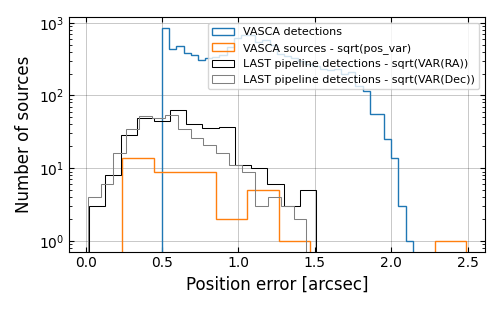

In [27]:
fig, ax = vutils.nb_fig(num="pos_err", gr_size=5, layout="tight")

ax.hist(
    tt_det["pos_err"],
    histtype="step",
    bins="auto",
    label="VASCA detections"
)
ax.hist(
    np.sqrt(tt_src["pos_var"]),
    #tt_src["pos_err"],
    histtype="step",
    bins="auto",
    label="VASCA sources - sqrt(pos_var)"
)

ax.hist(
    (np.sqrt(np.nanvar(hdf["RA"][:],ddof=1,axis=1)) * uu.deg).to("arcsec").data,
    histtype="step",
    bins="auto",
    color="k",
    lw=0.75,
    label="LAST pipeline detections - sqrt(VAR(RA))"
)
ax.hist(
    (np.sqrt(np.nanvar(hdf["Dec"][:],ddof=1,axis=1)) * uu.deg).to("arcsec").data,
    histtype="step",
    bins="auto",
    color="gray",
    lw=0.75,
    label="LAST pipeline detections - sqrt(VAR(Dec))"
)

ax.set_xlabel(f"Position error [arcsec]", fontsize=12)
ax.set_ylabel("Number of sources", fontsize=12)

ax.set_yscale("log")

ax.grid(True, linewidth=0.5, color="k", alpha=0.3, zorder=0)
ax.tick_params(axis="y", direction="in", left=True, right=True, which="both")
ax.tick_params(axis="x", direction="in", top=True, bottom=True, which="both")

ax.legend(fontsize=8)


# Diagnostics

## Load detection catalogs

In [28]:
# Loops over mcat files
# and create dictionary of detection catalogs
mcats = dict()
for i, path in enumerate(f_list_good):
    # Get visit ID
    with fits.open(path) as hdul:
        vis_id = hdul[0].header["IMG"]
    # Load mcat as table
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", AstropyWarning)
        tt_mcat = Table.read(path)
    
    # Add visit ID
    tt_mcat.add_column(
        np.full(len(tt_mcat), vis_id), name="visit_id", index=0
    )
    # Add filter ID
    tt_mcat.add_column(
        np.full(len(tt_mcat), vutils.dd_filter2id["NUV"]), name="obs_filter_id"
    )
    
    # Select subset of mcat columns 
    tt_mcat = tt_mcat[mcat_col_names]
    
    # Rename columns
    tt_mcat.rename_columns(mcat_col_names, vasca_col_names)
    
    mcats[vis_id] = tt_mcat

## Show detections on sky (raw mcat)

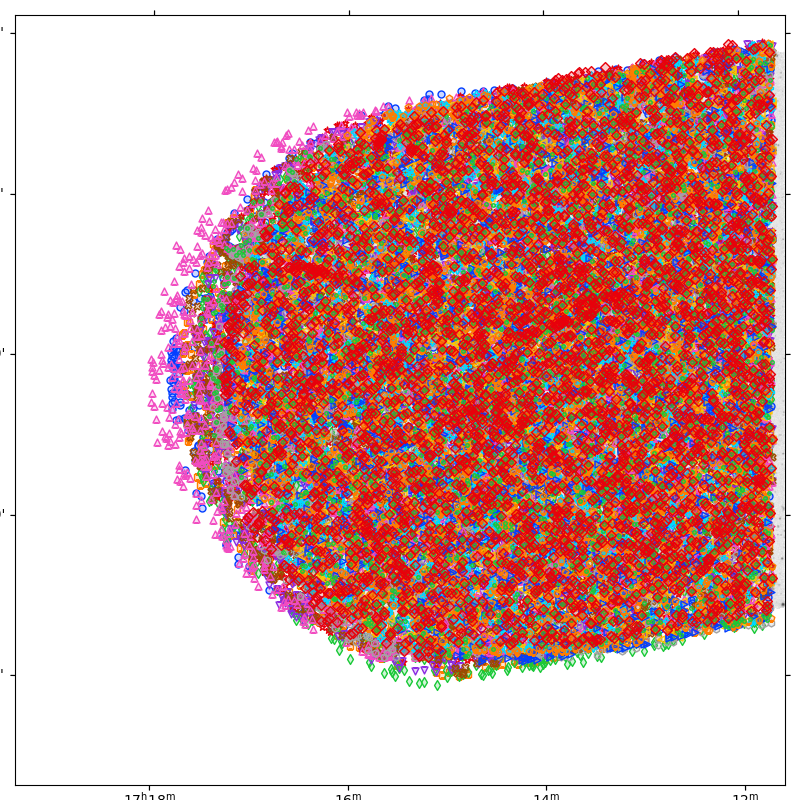

In [29]:
plt.close("red_int")
fig, ax = vutils.nb_fig(
    num="ref_int",
    figsize=(8,8),
    layout="tight",
    subplot_kw={'projection': fd.ref_wcs}
)

# Reference image
ax.imshow(fd.ref_img, norm=LogNorm(), cmap="gray_r")

ax.set_autoscale_on(False)

# Detections
n_visits = len(mcats.keys())
markers = vutils.marker_set(n_visits)
colors = vutils.color_palette("bright", n_visits)

for i, (vis_id, tt_mcat) in enumerate(mcats.items()):
    coords = vutils.table_to_array(tt_mcat["ra","dec"])
    ax.scatter(
        coords[:,0],
        coords[:,1],
        transform=ax.get_transform('fk5'),
        marker=markers[i],
        edgecolor=colors[i],
        facecolor=(*colors[i][:3],0.2),
        s=5**2,
    )   

## Show detections on sky (VASCA-selected)

5085


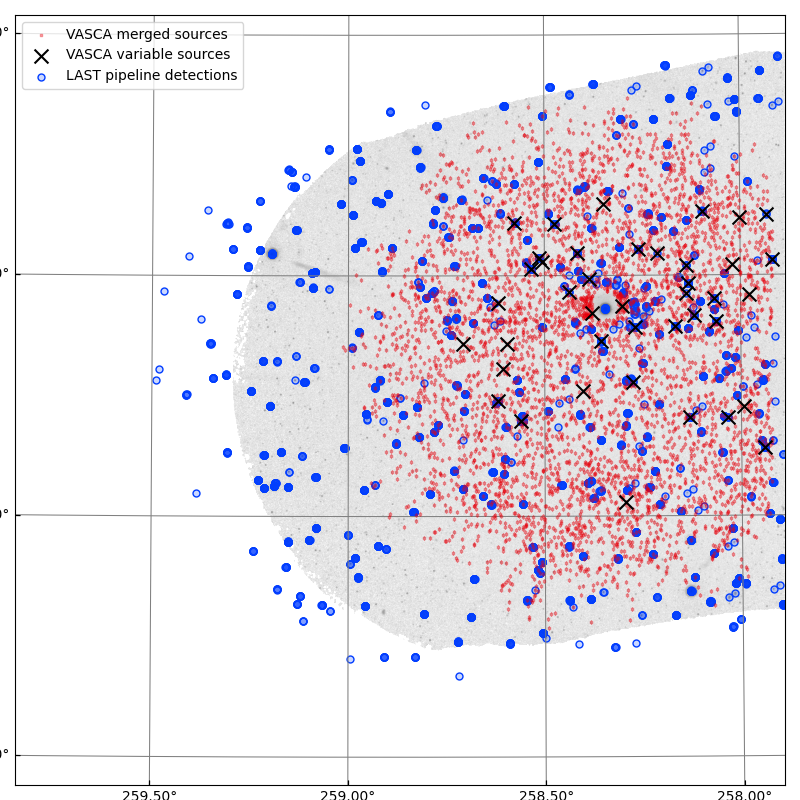

In [30]:
plot_det = False
plot_vasca = True
plot_vasca_var = True
plot_wis = True


plot_name = "ref_int_vasca_det"
plt.close(plot_name)
fig, ax = vutils.nb_fig(
    num=plot_name,
    figsize=(8,8),
    layout="tight",
    subplot_kw={'projection': fd.ref_wcs}
)

# Reference image
ax.imshow(fd.ref_img, norm=LogNorm(), cmap="gray_r")

ax.set_autoscale_on(False)

# Detections
vis_ids = list(mcats.keys())
n_visits = len(vis_ids)
markers = vutils.marker_set(n_visits)
colors = vutils.color_palette("bright", n_visits)

if plot_det:
    for i, vis_id in enumerate(vis_ids):
        sel_vis = fd.tt_detections["vis_id"] == vis_id
        sel_det_qual = fd.tt_detections["sel"]#[:,0]
        tt_mcat = fd.tt_detections[sel_vis*sel_det_qual]
        #coords = SkyCoord(ra=tt_mcat["ra"].data, dec=tt_mcat["dec"].data, unit="deg", frame="icrs")
        coords = vutils.table_to_array(tt_mcat["ra","dec"])
        ax.scatter(
            coords[:,0],
            coords[:,1],
            transform=ax.get_transform('fk5'),
            marker=markers[i],
            edgecolor=colors[i],
            facecolor=(*colors[i][:3],0.2),
            s=2**2,
            zorder=2,
            label="GALEX pipeline detections" if i==0 else "_",
        )

if plot_vasca:
    # VASCA sources
    tt_sources = fd.tt_sources[fd.tt_sources["nr_det"][:,0]>=1]
    #tt_sources = fd.tt_sources[fd.tt_sources["sel"][:,0]]
    coords = vutils.table_to_array(tt_sources["ra","dec"])
    print(len(coords))
    ax.scatter(
        coords[:,0],
        coords[:,1],
        transform=ax.get_transform('fk5'),
        marker="s",
        edgecolor=(*colors[3][:3], 0.4),
        facecolor=(*colors[3][:3], 0.2),
        s=2**2,
        zorder=3,
        label="VASCA merged sources",
    )

if plot_vasca_var:
    # VASCA varaible sources
    tt_sources = fd.tt_sources[fd.tt_sources["sel"][:,0]]
    coords = vutils.table_to_array(tt_sources["ra","dec"])
    ax.scatter(
        coords[:,0],
        coords[:,1],
        transform=ax.get_transform('fk5'),
        marker="x",
        color="k",
        #edgecolor=colors[i],
        #facecolor=(*colors[i][:3],0.2),
        s=10**2,
        zorder=4,
        label="VASCA variable sources",
    )
    
if plot_wis:
    for i in range(14):
        tt_wis = Table({"ra":hdf["RA"][:,i], "dec":hdf["Dec"][:,i]})
        sel_nnan = np.isnan(tt_wis["ra"])
        coords = vutils.table_to_array(tt_wis)

        ax.scatter(
            coords[:,0],
            coords[:,1],
            transform=ax.get_transform('fk5'),
            marker="o",
            #color="r",
            edgecolor=colors[0],
            facecolor=(*colors[0][:3],0.2),
            s=5**2,
            zorder=1,
            label="LAST pipeline detections" if i==0 else "_",
        )

 # modify grid
ax.coords.grid(True, color='gray', lw=0.75, ls='-', zorder=0)

# set axis labels
ra = ax.coords["ra"]
dec = ax.coords["dec"]
ra.set_major_formatter("d.dd")
dec.set_major_formatter("d.dd")

label_fontsize = 10
ax.set_xlabel("Ra", fontsize=label_fontsize)
ax.set_ylabel("Dec", fontsize=label_fontsize)
ax.xaxis.set_tick_params(labelsize=label_fontsize)
ax.yaxis.set_tick_params(labelsize=label_fontsize)
ax.tick_params(axis="x", labelsize=label_fontsize, direction="in", bottom=True, top=False)
ax.tick_params(axis="y", labelsize=label_fontsize, direction="in", left=True, right=False)

ax.legend(fontsize=label_fontsize)

## FLux error vs. magnitude

3706


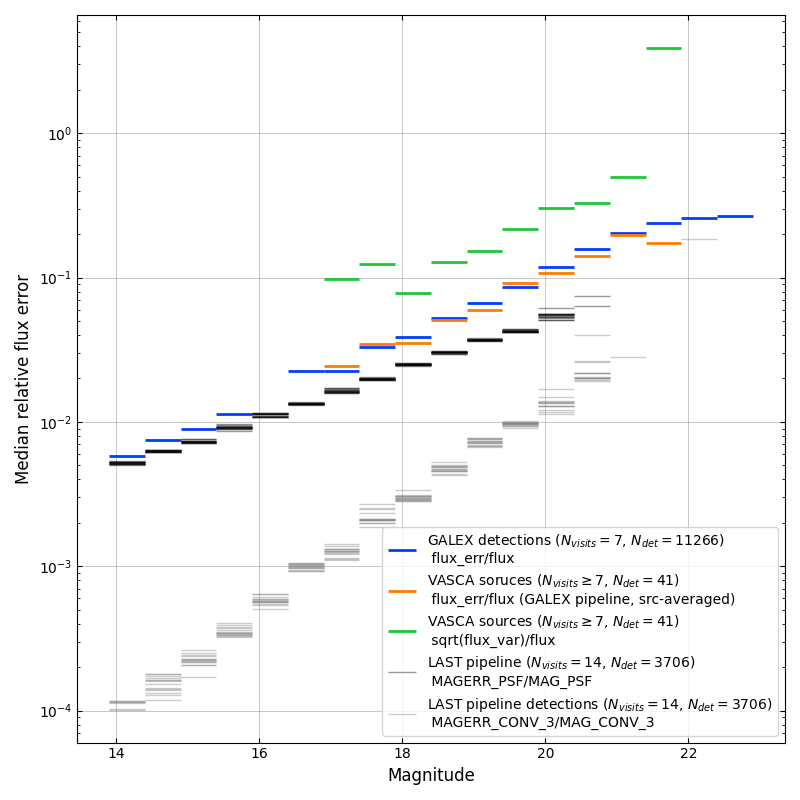

In [31]:
# Select data from field

# VASCA Detections
tt_det_selected = fd.tt_detections[fd.tt_detections["sel"]]
det_mag, det_mag_err = vutils.flux2mag(
    tt_det_selected["flux"], tt_det_selected["flux_err"]
)
bins = vutils.get_hist_bins(det_mag.data, 0.5)
# bins = np.arange(12,24,0.5)


# VASCA Sources

# Select by number of visits alone
#n_vis_lim = 2
#tt_src_selected = fd.tt_sources[fd.tt_sources["nr_det"][:,0]>=n_vis_lim]

# Select on variablity cuts
tt_src_selected = fd.tt_sources[fd.tt_sources["sel"][:, 0]]
n_vis_lim = 7#tt_src_selected["nr_det"].min()

src_mag, src_mag_err = vutils.flux2mag(
    tt_src_selected["flux"][:, 0], tt_src_selected["flux_err"][:, 0]
)

# Plot

fig, ax = vutils.nb_fig(num="fvm", figsize=(8, 8), layout="tight")

# Line colors
colors = vutils.color_palette("bright", 5) 


# Binning statisitc
statistic = "median"

# GALEX pipeline detections
flux_means, bin_edges, binnumber = binned_statistic(
    det_mag, tt_det_selected["flux"], statistic=statistic, bins=bins
)
flux_err_means, bin_edges, binnumber = binned_statistic(
    det_mag, tt_det_selected["flux_err"], statistic=statistic, bins=bins
)

ax.hlines(
    flux_err_means / flux_means,
    bin_edges[:-1],
    bin_edges[1:],
    colors=colors[0],
    lw=2,
    label=(
        "GALEX detections "
        f"($N_{{visits}} = 7$, $N_{{det}}={len(tt_det_selected)}$)\n "
        "flux_err/flux"
    ),
)

# VASCA-clustered sources -> GALEX pipeline error
flux_means, bin_edges, binnumber = binned_statistic(
    src_mag, tt_src_selected["flux"][:, 0], statistic=statistic, bins=bins
)
n_dets, _, _ = binned_statistic(
    src_mag, tt_src_selected["nr_det"][:, 0], statistic=statistic, bins=bins
)
flux_err_means, bin_edges, binnumber = binned_statistic(
    src_mag, tt_src_selected["flux_err"][:, 0], statistic=statistic, bins=bins
)

ax.hlines(
    flux_err_means * np.sqrt(n_dets) / flux_means,
    bin_edges[:-1],
    bin_edges[1:],
    colors=colors[1],
    lw=2,
    label=(
        "VASCA soruces "
        f"($N_{{visits}} \\geq {n_vis_lim}$, $N_{{det}}={len(tt_src_selected)}$)\n "
        "flux_err/flux (GALEX pipeline, src-averaged)"
    ),
)

# VASCA-clustered sources -> Flux variance error
flux_means, bin_edges, binnumber = binned_statistic(
    src_mag, tt_src_selected["flux"][:, 0], statistic=statistic, bins=bins
)
n_dets, _, _ = binned_statistic(
    src_mag, tt_src_selected["nr_det"][:, 0], statistic=statistic, bins=bins
)
flux_err_means, bin_edges, binnumber = binned_statistic(
    src_mag, np.sqrt(tt_src_selected["flux_var"][:, 0]), statistic=statistic, bins=bins
)

ax.hlines(
    flux_err_means / flux_means, #/ np.sqrt(n_dets),
    bin_edges[:-1],
    bin_edges[1:],
    colors=colors[2],
    lw=2,
    label=(
        "VASCA sources "
        f"($N_{{visits}} \\geq {n_vis_lim}$, $N_{{det}}={len(tt_src_selected)}$)\n "
        "sqrt(flux_var)/flux"
    ),
)

# LAST PSF photometry
n_det_wis = 0
for i in range(14):
    n_det_wis += (~np.isnan(hdf["MAGERR_PSF"][:, i])).sum()
print(n_det_wis)

for i in range(14):
    mag = hdf["MAG_PSF"][:, i][~np.isnan(hdf["MAG_PSF"][:, i])]
    mag_err = hdf["MAGERR_PSF"][:, i][~np.isnan(hdf["MAGERR_PSF"][:, i])]
    mag_means, bin_edges, binnumber = binned_statistic(
        mag, mag, statistic=statistic, bins=bins
    )
    mag_err_means, bin_edges, binnumber = binned_statistic(
        mag, mag_err, statistic=statistic, bins=bins
    )

    ax.hlines(
        mag_err_means / mag_means,
        bin_edges[:-1],
        bin_edges[1:],
        colors="black",
        alpha=0.4,
        lw=1,
        label=(
            (
                "LAST pipeline "
                f"($N_{{visits}} = 14$, $N_{{det}}={n_det_wis}$)\n MAGERR_PSF/MAG_PSF"
            )
            if i == 0
            else "_"
        ),
    )

# LAST other
for i in range(14):
    mag = hdf["MAG_CONV_3"][:, i][~np.isnan(hdf["MAG_CONV_3"][:, i])]
    mag_err = hdf["MAGERR_CONV_3"][:, i][~np.isnan(hdf["MAGERR_CONV_3"][:, i])]
    mag_means, bin_edges, binnumber = binned_statistic(
        mag, mag, statistic=statistic, bins=bins
    )
    mag_err_means, bin_edges, binnumber = binned_statistic(
        mag, mag_err, statistic=statistic, bins=bins
    )

    ax.hlines(
        mag_err_means / mag_means,
        bin_edges[:-1],
        bin_edges[1:],
        colors="gray",
        alpha=0.4,
        lw=1,
        label=(
            (
                "LAST pipeline detections "
                f"($N_{{visits}} = 14$, $N_{{det}}={n_det_wis}$)\n "
                "MAGERR_CONV_3/MAG_CONV_3"
            )
            if i == 0
            else "_"
        ),
    )

# Plot settings
ax.set_xlabel(f"Magnitude", fontsize=12)
ax.set_ylabel("Median relative flux error", fontsize=12)

ax.set_yscale("log")

ax.grid(True, linewidth=0.5, color="k", alpha=0.3, zorder=0)
ax.tick_params(axis="y", direction="in", left=True, right=True, which="both")
ax.tick_params(axis="x", direction="in", top=True, bottom=True, which="both")

_ = ax.legend(fontsize=10, loc="lower right")


KeyError: 'No matches found for key 0'

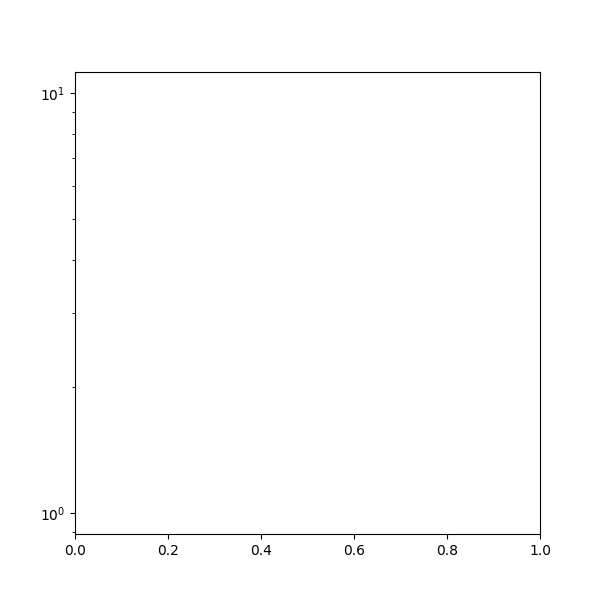

In [32]:
ids = fd.tt_sources[fd.tt_sources["sel"][:,0]]["fd_src_id"].data.astype(int)
vvis.plot_light_curve(fd, fd_src_ids=[0])

## x-match VASCA-LAST

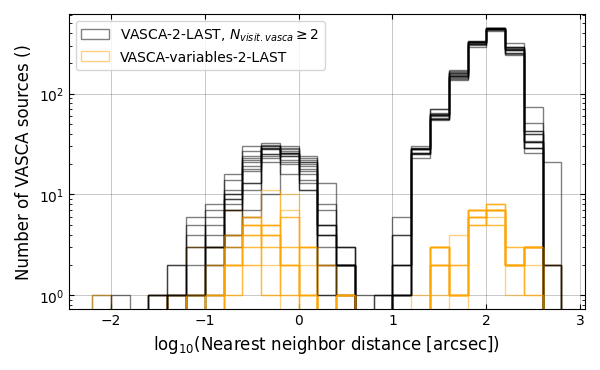

In [33]:
fig, ax = vutils.nb_fig(num="xmatch", gr_size=6, layout="tight")
pos_vasca = SkyCoord(fd.tt_sources["ra"][fd.tt_sources["nr_det"][:,0]>=2], fd.tt_sources["dec"][fd.tt_sources["nr_det"][:,0]>=2], unit="deg", frame="icrs")
pos_vasca_var = SkyCoord(fd.tt_sources["ra"][fd.tt_sources["sel"][:,0]], fd.tt_sources["dec"][fd.tt_sources["sel"][:,0]], unit="deg", frame="icrs")

dists = list()
dists_var = list()
for i in range(14):
    pos_last = SkyCoord(hdf["RA"][:,i][~np.isnan(hdf["RA"][:,i])], hdf["Dec"][:,i][~np.isnan(hdf["Dec"][:,i])], unit="deg", frame="icrs")
    match_idx, match_dist, _ = match_coordinates_sky(pos_vasca, pos_last)
    dists.append(match_dist.to("arcsec").data)
    
    match_idx, match_dist, _ = match_coordinates_sky(pos_vasca_var, pos_last)
    dists_var.append(match_dist.to("arcsec").data)

bins = vutils.get_hist_bins(np.log10(dists), 0.2)
for i in range(14):
    ax.hist(
        np.log10(dists[i]),
        histtype="step",
        color="k",
        alpha=0.5,
        bins=bins,
        label="VASCA-2-LAST, $N_{{visit.vasca}}\\geq 2$" if i==0 else "_",
    )
    ax.hist(
        np.log10(dists_var[i]),
        histtype="step",
        color="orange",
        alpha=0.5,
        bins=bins,
        label="VASCA-variables-2-LAST" if i==0 else "_",
    )

# Plot settings
ax.set_xlabel(f"log$_{{10}}$(Nearest neighbor distance [arcsec])", fontsize=12)
ax.set_ylabel("Number of VASCA sources ()", fontsize=12)

ax.set_yscale("log")

ax.grid(True, linewidth=0.5, color="k", alpha=0.3, zorder=0)
ax.tick_params(axis="y", direction="in", left=True, right=True, which="both")
ax.tick_params(axis="x", direction="in", top=True, bottom=True, which="both")

ax.legend(loc="upper left")

## Reduced chi2

/var/folders/__/9_mqtndn7l5d4xsxr82pvg6r0000gn/T/ipykernel_98814/2887232891.py:4: RuntimeWarning: invalid value encountered in log10
  np.log10(fd.tt_sources["flux_rchiq"][:,0]),


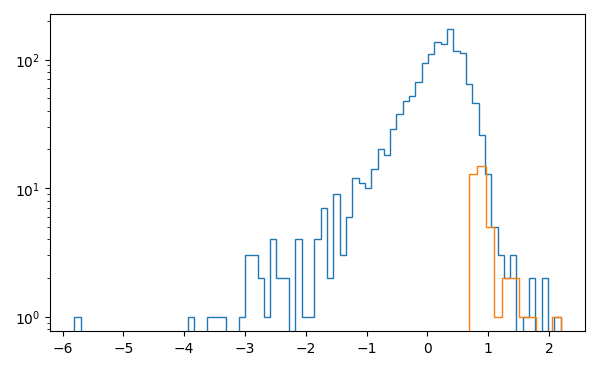

In [34]:
fig, ax = vutils.nb_fig(num="rchi2", gr_size=6, layout="tight")

ax.hist(
    np.log10(fd.tt_sources["flux_rchiq"][:,0]),
    bins="auto",
    histtype="step",
)
ax.hist(
    np.log10(fd.tt_sources["flux_rchiq"][fd.tt_sources["sel"][:,0]][:,0]),
    bins="auto",
    histtype="step",
)
#ax.set_xscale("log")
ax.set_yscale("log")

## p-value

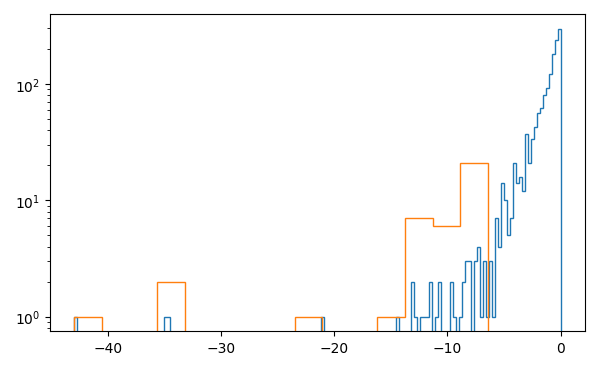

In [35]:
fig, ax = vutils.nb_fig(num="pval", gr_size=6, layout="tight")

ax.hist(
    np.log10(fd.tt_sources["flux_cpval"][:,0][fd.tt_sources["flux_cpval"][:,0]>0]),
    bins="auto",
    histtype="step",
)
ax.hist(
    np.log10(fd.tt_sources["flux_cpval"][fd.tt_sources["sel"][:,0]][:,0][fd.tt_sources["flux_cpval"][fd.tt_sources["sel"][:,0]][:,0]>0]),
    bins="auto",
    histtype="step",
)
#ax.set_xscale("log")
ax.set_yscale("log")

In [36]:
fd.tt_sources["flux_cpval"][:,0] < 0

array([False, False, False, ...,  True,  True,  True])

In [37]:
fd.tt_sources

<Table length=5085>
fd_src_id  nr_det          ra                dec          pos_err      pos_nxv     ...   flux_nxv    flux_var    flux_cpval  flux_rchiq assoc_ffactor assoc_fdiff_s2n
                          deg                deg           arcsec                  ...              1e-12 Jy2                                                        
  int32   int32[1]      float64            float64        float32      float32     ...  float32[1]  float32[1]   float32[1]  float32[1]    float32        float32    
--------- -------- ------------------ ------------------ ---------- -------------- ... ------------ ---------- ------------- ---------- ------------- ---------------
        0       14  258.5347595243532  35.51409577246547 0.13363062  -5.054034e-12 ...  0.009620929  2700.8137           0.0  21.488817        -100.0        -10000.0
        1       14    257.97818783939  35.03875059634047 0.15031686  1.4250191e-13 ...  0.004445333   26.77902   0.094802044  1.5397232        -100.0        -10000.0
        2       14  257.9504515380369  35.52782701554327 0.23539282 -1.1372707e-11 ... -0.012650477   6.048381     0.5077219  0.9418677        -100.0        -10000.0
        3       13 258.79037790623875   35.3902348991654 0.19164406  1.3610158e-12 ...  0.017889872   23.37789   0.011038413  2.1595051        -100.0        -10000.0
        4       13  258.7472079513991  35.41860780481523 0.24589066   7.519228e-11 ...   0.09254986  20.496698 3.5347646e-05  3.4871922        -100.0        -10000.0
        5       13  258.7258890085921 35.411411467531074 0.13867505  5.7975963e-12 ... 0.0017112901  157753.98           0.0  58.544846        -100.0        -10000.0
        6       13  258.6384173213169  35.06900783771947 0.19130826  1.0582597e-11 ...  0.053840842  28.713652  0.0014211893  2.6604085        -100.0        -10000.0
        7       13  258.6177068953904  35.44350418807864 0.27911922  3.9754857e-12 ...   0.38180792  49.511276  9.654575e-09  5.1681247        -100.0        -10000.0
        8       13 258.55645022312734 35.025557309138506 0.13922347  -4.748624e-12 ... 0.0046832026    90.5636  0.0007341736  2.8138678        -100.0        -10000.0
        9       13  258.5062846151158  35.39315146022217 0.13867505 -6.5936557e-12 ...  0.002569421  10274.746           0.0  26.974703        -100.0        -10000.0
       10       13  258.4822652866912  35.49930100370469  0.2214329  -5.827533e-12 ...   0.03401878   21.77507   0.012438732  2.1288025        -100.0        -10000.0
       11       13  258.4762207649423 34.970935765389804 0.21887341  1.2121646e-11 ...  0.011173127  11.061809    0.14607777  1.4245399        -100.0        -10000.0
       12       13  258.3772434185994 35.038179637863294  0.1448061  -6.256581e-12 ... 0.0036853873  49.421967   0.062146075  1.6891747        -100.0        -10000.0
       13       13 258.35176129870814 34.982403115663814 0.25882858 1.07876616e-11 ...  0.019410515   9.475631   0.044518765  1.7852513        -100.0        -10000.0
       14       13  258.2428046310564  35.46438292501268 0.21361332  -9.764777e-12 ...    0.0416082   13.75353  0.0011372243  2.7125456        -100.0        -10000.0
       15       13 258.17118933581577 35.590958803446036 0.14869222 -1.8444025e-12 ...  0.013183261  54.135876  3.374602e-05   3.497172        -100.0        -10000.0
       16       13  258.1682054363631  35.48195395643977 0.19789438  -8.050601e-12 ...   0.05366218  28.476906 9.8189375e-06  3.7602034        -100.0        -10000.0
       17       13 258.15340551482944  35.49245462325249 0.23136973 -1.4441022e-11 ...   0.04771619  15.779798  0.0009889023  2.7450478        -100.0        -10000.0
      ...      ...                ...                ...        ...            ... ...          ...        ...           ...        ...           ...             ...
     5067        1 257.92538430452197   35.4120246199522  1.2388825         -100.0 ...       -100.0     -100.0          -1.0       -1.0        -100.0        -1000